In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error
import sklearn.model_selection
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

! pip install adabound
from adabound import AdaBound

In [5]:
#kwdikas apo github slp
class pyData(Dataset):
    def __init__(self, X, y, trans=None):
        self.data = list(zip(X, y))
        self.trans = trans
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.trans is not None:
            return self.trans(self.data[idx])
        else:
            return self.data[idx]

class ToTensor(object):
    def __init__(self):
          pass
        
    def __call__(self, datum):
        x, y = datum[0], datum[1]
        t = torch.from_numpy(x).type(torch.FloatTensor) 
        y = torch.from_numpy(y).type(torch.FloatTensor)
        return t, y

In [6]:
class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size1, output_size):
            super(Feedforward, self).__init__()
            self.fc1 = nn.Linear(input_size,hidden_size1)
            self.relu1 = nn.ReLU() 
            self.fc2 = nn.Linear(hidden_size1,output_size)
            # self.relu2 = nn.ReLU() 
            # self.fc3 = nn.Linear(hidden_size2,output_size)

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu1(out)
            output = self.fc2(out)
            # out = self.relu2(out)
            # output = self.fc3(out)
            return output

In [7]:
def train_nn(net,EPOCHS,train_dl,criterion,optimizer):
  net.train() # gradients "on"
  for epoch in range(EPOCHS): # loop through dataset
      running_average_loss = 0
      for i, data in enumerate(train_dl): # loop thorugh batches
          X_batch, y_batch = data # get the input and output
          optimizer.zero_grad()
          out = net(X_batch) # forward pass
          # if epoch % 5 == 0 and i % 50 == 0:
          #     print(epoch,i)
          #     print(y_batch)
          #     print(out)
          loss = criterion(out, y_batch) # compute per batch loss 
          loss.backward() # compurte gradients based on the loss function
          optimizer.step() # update weights 
          
      running_average_loss += loss.detach().item()
      if epoch % 100 == 0:
        print("Epoch: {} \t Batch: {} \t Loss {}".format(epoch, i, float(running_average_loss) / (i + 1)))

In [8]:
data = pd.read_csv('data_NN.csv',delimiter=";")
data = data.to_numpy()
stringer = lambda stringaki: float(stringaki.replace(",","."))
vfunc = np.vectorize(stringer)
data = vfunc(data)
x0 = np.array([[-2,0,-1]],dtype = 'float64')
indata = np.concatenate((x0,data[0:999]),axis = 0)
x1,y1,z1 = np.amin(indata,axis = 0)
x2,y2,z2 = np.amin(data,axis = 0)

x1 , x2 = min(x1,x2) , min(x1,x2)
y1 , y2 = min(y1,y2) , min(y1,y2)
z1 , z2 = min(z1,z2) , min(z1,z2)

# print(np.amin(indata,axis = 0))
# print(np.amin(data,axis = 0))

for i in range(indata.shape[0]):
    indata[i][0] = indata[i][0] / x1
    indata[i][1] = indata[i][1] / y1
    indata[i][2] = indata[i][2] / z1
    data[i][0] = data[i][0] / x2
    data[i][1] = data[i][1] / y2
    data[i][2] = data[i][2] / z2

# print(np.amin(indata,axis = 0))
# print(np.amin(data,axis = 0))


all_data = pyData(indata,data,trans=ToTensor())
all_dl = DataLoader(all_data, batch_size=1, shuffle=False)

In [9]:
BATCH_SZ = 10

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(indata, data, test_size = .2,shuffle = False)
train_data = pyData(X_train, y_train, trans=ToTensor())
test_data  = pyData(X_test, y_test, trans=ToTensor())
train_dl = DataLoader(train_data, batch_size=BATCH_SZ, shuffle=False)
test_dl = DataLoader(test_data, batch_size=1, shuffle=False)


In [24]:
net = Feedforward(3,32,3)
# net = Feedforward(3,32,32,3)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# net = net.to(device)

train_nn(net,EPOCHS = 1000,train_dl=train_dl,criterion = nn.MSELoss(),optimizer = AdaBound(net.parameters(), lr=0.001, final_lr=0.1) )

/usr/local/lib/python3.6/dist-packages/adabound/adabound.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Epoch: 0 	 Batch: 79 	 Loss 0.0011415120214223861
Epoch: 100 	 Batch: 79 	 Loss 1.588142549735494e-06
Epoch: 200 	 Batch: 79 	 Loss 7.758859283057973e-07


KeyboardInterrupt: ignored

Loss = 0.0005269056877954079
Loss = 0.001851583172188986


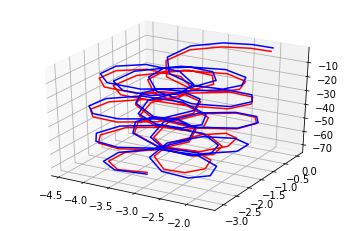

In [25]:
start = torch.from_numpy(np.array([-1.9/x1,0,-0.9/z1],dtype = "float32"))
# print(net(torch.from_numpy(np.array([-1.9,0,-0.9],dtype = "float32"))))
x ,y ,z = [-2] , [0], [-1]
for i in range(200):
    next = net(start)
    start = next
    x.append(next[0]*x2)
    y.append(next[1]*y2)
    z.append(next[2]*z2)

ax = plt.axes(projection='3d')
ax.plot3D(x, y, z, marker='x', markersize = 1)
plt.savefig("3.jpg")

x ,y ,z = [] , [], []
xold ,yold ,zold = [] , [], []

loss = 0
for i, curdata in enumerate(test_dl): # loop thorugh batches
    X_batch, y_batch = curdata    
    next = net(X_batch)
    loss += mean_squared_error(y_batch.detach().numpy(),next.detach().numpy())

    x.append(next[0][0]*x2)
    y.append(next[0][1]*y2)
    z.append(next[0][2]*z2)
    xold.append(y_batch[0][0]*x2)
    yold.append(y_batch[0][1]*y2)
    zold.append(y_batch[0][2]*z2)

print("Loss =",loss/i)
# Data for a three-dimensional line
axs = plt.axes(projection='3d')
axs.plot3D(x, y, z, 'red')
axs.plot3D(xold, yold, zold, 'green')
plt.savefig("2.jpg")

x ,y ,z = [] , [], []
xold ,yold ,zold = [] , [], []

for i, curdata in enumerate(all_dl): # loop thorugh batches
    X_batch, y_batch = curdata    
    next = net(X_batch)
    loss += mean_squared_error(y_batch.detach().numpy(),next.detach().numpy())

    x.append(next[0][0]*x2)
    y.append(next[0][1]*y2)
    z.append(next[0][2]*z2)
    xold.append(y_batch[0][0]*x2)
    yold.append(y_batch[0][1]*y2)
    zold.append(y_batch[0][2]*z2)


print("Loss =",loss/i)
# Data for a three-dimensional line
ax = plt.axes(projection='3d')

ax.plot3D(x, y, z, 'red')
ax.plot3D(xold, yold, zold, 'blue')
plt.savefig("3.jpg")

In [ ]:
for nodes in [8]:
    for epoch in [4000]:
        for batch in [10]:
            lr = .00001
            final_lr = .01
    # for lr in [.1,.01,.001,.0001]:
    #     for final_lr in [.1,.01,.001]:
    #         epoch = 200
    #         batch = 20
            print("Nodes, epoch, batch =",nodes,epoch,batch)
            X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(indata, data, test_size = .2,shuffle = False)
            train_data = pyData(X_train, y_train, trans=ToTensor())
            test_data  = pyData(X_test, y_test, trans=ToTensor())
            train_dl = DataLoader(train_data, batch_size=batch, shuffle=True)
            test_dl = DataLoader(test_data, batch_size=1, shuffle=False)

            net = Feedforward(3,nodes,3)
            # net = Feedforward(3,32,32,3)

            # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            # net = net.to(device)

            train_nn(net,EPOCHS = epoch,train_dl=all_dl,criterion = nn.MSELoss(),optimizer = AdaBound(net.parameters(), lr = lr, final_lr = final_lr) )

            start = torch.from_numpy(np.array([-1.9/x1,0,-0.9/z1],dtype = "float32"))
            # print(net(torch.from_numpy(np.array([-1.9,0,-0.9],dtype = "float32"))))
            x ,y ,z = [-1.9] , [0], [-0.9]
            xold ,yold ,zold = [-2] , [0], [-1]
            for i, curdata in enumerate(all_dl): # loop thorugh batches
                _,y_batch = curdata
                if i == 1000:
                    break
                
                next = net(start)
                start = next
                xold.append(y_batch[0][0]*x2)
                yold.append(y_batch[0][1]*y2)
                zold.append(y_batch[0][2]*z2)
                x.append(next[0]*x2)
                y.append(next[1]*y2)
                z.append(next[2]*z2)

            ax = plt.axes(projection='3d')
            ax.plot3D(x, y, z, 'red')
            ax.plot3D(xold, yold, zold, 'blue')
            plt.savefig("1/nodes_" + str(nodes) +"_epoch_" + str(epoch) + "_batch_" + str(batch) + "_1.jpg")

            x ,y ,z = [] , [], []
            xold ,yold ,zold = [] , [], []

            loss = 0
            for i, curdata in enumerate(test_dl): # loop thorugh batches
                X_batch, y_batch = curdata    
                next = net(X_batch)
                loss += mean_squared_error(y_batch.detach().numpy(),next.detach().numpy())

                x.append(next[0][0]*x2)
                y.append(next[0][1]*y2)
                z.append(next[0][2]*z2)
                xold.append(y_batch[0][0]*x2)
                yold.append(y_batch[0][1]*y2)
                zold.append(y_batch[0][2]*z2)

            print("Loss =",loss/i)
            # Data for a three-dimensional line
            axs = plt.axes(projection='3d')
            axs.plot3D(x, y, z, 'red')
            axs.plot3D(xold, yold, zold, 'green')
            plt.savefig("2/epoch_" + str(epoch) + "_batch_" + str(batch) + "_2.jpg")

            x ,y ,z = [] , [], []
            xold ,yold ,zold = [] , [], []

            for i, curdata in enumerate(all_dl): # loop thorugh batches
                X_batch, y_batch = curdata    
                next = net(X_batch)
                loss += mean_squared_error(y_batch.detach().numpy(),next.detach().numpy())

                x.append(next[0][0]*x2)
                y.append(next[0][1]*y2)
                z.append(next[0][2]*z2)
                xold.append(y_batch[0][0]*x2)
                yold.append(y_batch[0][1]*y2)
                zold.append(y_batch[0][2]*z2)


            print("Loss =",loss/i)
            # Data for a three-dimensional line
            ax = plt.axes(projection='3d')

            ax.plot3D(x, y, z, 'red')
            ax.plot3D(xold, yold, zold, 'blue')
            plt.savefig("3/epoch_" + str(epoch) + "_batch_" + str(batch) + "_3.jpg")


In [ ]:
!rm -rf 1
!rm -rf 2
!rm -rf 3
!mkdir 1
!mkdir 2
!mkdir 3


In [ ]:
from google.colab import files
!zip -r 1.zip 1
files.download('1.zip')
# !zip -r 2.zip 2
# files.download('2.zip')
# !zip -r 3.zip 3
# files.download('3.zip')

# files.download('2')
# files.download('3') 

In [33]:
torch.save(net, "nodes8epoch4000batch10 (1).txt")

In [12]:
# model = torch.load("nodes8epoch4000batch10.txt")
# print(net(torch.from_numpy(np.array([-1.9,0,-0.9],dtype = "float32"))))
# print(model(torch.from_numpy(np.array([-1.9,0,-0.9],dtype = "float32"))))
model = torch.load("nodes8epoch4000batch10 (1).txt")
print(model(torch.from_numpy(np.array([-1.9,0,-0.9],dtype = "float32"))))

tensor([0.1814, 0.0700, 0.1213], grad_fn=<AddBackward0>)


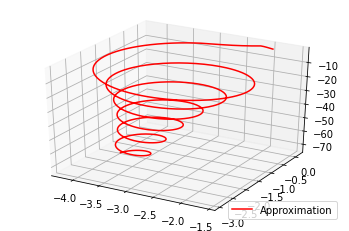

In [35]:
            start = torch.from_numpy(np.array([-1.9/x1,0,-0.9/z1],dtype = "float32"))
            # print(net(torch.from_numpy(np.array([-1.9,0,-0.9],dtype = "float32"))))
            x ,y ,z = [-1.9] , [0], [-0.9]
            xold ,yold ,zold = [-2] , [0], [-1]
            for i, curdata in enumerate(all_dl): # loop thorugh batches
                _,y_batch = curdata
                # print(i)
                if i > 200:
                    break
                next = model(start)
                start = next
                xold.append(y_batch[0][0]*x2)
                yold.append(y_batch[0][1]*y2)
                zold.append(y_batch[0][2]*z2)
                x.append(next[0]*x2)
                y.append(next[1]*y2)
                z.append(next[2]*z2)

            ax = plt.axes(projection='3d')
            ax.plot3D(x, y, z, 'red')
            # ax.plot3D(xold, yold, zold, 'blue')
            ax.legend(["Approximation","Real data"],loc = 'lower right')
            plt.savefig("Steps" + str(1000) + ".jpg")


In [ ]:

            # plt.savefig("1/nodes_" + str(nodes) +"_epoch_" + str(epoch) + "_batch_" + str(batch) + "_1.jpg")

            x ,y ,z = [] , [], []
            xold ,yold ,zold = [] , [], []

            loss = 0
            for i, curdata in enumerate(test_dl): # loop thorugh batches
                X_batch, y_batch = curdata    
                next = model(X_batch)
                loss += mean_squared_error(y_batch.detach().numpy(),next.detach().numpy())

                x.append(next[0][0]*x2)
                y.append(next[0][1]*y2)
                z.append(next[0][2]*z2)
                xold.append(y_batch[0][0]*x2)
                yold.append(y_batch[0][1]*y2)
                zold.append(y_batch[0][2]*z2)

            print("Loss =",loss/i)
            # Data for a three-dimensional line
            axs = plt.axes(projection='3d')
            axs.plot3D(x, y, z, 'red')
            axs.plot3D(xold, yold, zold, 'green')
            # plt.savefig("2/epoch_" + str(epoch) + "_batch_" + str(batch) + "_2.jpg")

            x ,y ,z = [] , [], []
            xold ,yold ,zold = [] , [], []

            for i, curdata in enumerate(all_dl): # loop thorugh batches
                X_batch, y_batch = curdata    
                next = model(X_batch)
                loss += mean_squared_error(y_batch.detach().numpy(),next.detach().numpy())

                x.append(next[0][0]*x2)
                y.append(next[0][1]*y2)
                z.append(next[0][2]*z2)
                xold.append(y_batch[0][0]*x2)
                yold.append(y_batch[0][1]*y2)
                zold.append(y_batch[0][2]*z2)


            print("Loss =",loss/i)
            # Data for a three-dimensional line
            ax = plt.axes(projection='3d')

            ax.plot3D(x, y, z, 'red')
            ax.plot3D(xold, yold, zold, 'blue')
            # plt.savefig("3/epoch_" + str(epoch) + "_batch_" + str(batch) + "_3.jpg")

In [ ]:
def plotter(net,indata,outdata,iteration,x2,y2,z2):
            x ,y ,z = [] , [], []
            xold ,yold ,zold = [] , [], []

            for i in range(len(indata)): 
                temp = np.array([indata[i][0],indata[i][1],indata[i][2]],dtype = "float32")
                X_batch = torch.from_numpy(temp)
                next = model(X_batch)
                # print(next)
                # loss += mean_squared_error(y_batch.detach().numpy(),next.detach().numpy())

                x.append(next[0]*x2)
                y.append(next[1]*y2)
                z.append(next[2]*z2)
                xold.append(outdata[i][0]*x2)
                yold.append(outdata[i][1]*y2)
                zold.append(outdata[i][2]*z2)

            ax = plt.axes(projection='3d')

            ax.plot3D(x, y, z, 'red')
            ax.plot3D(xold, yold, zold, 'green')
            ax.legend(["Approximation","Input data"],loc = 'lower right')
            plt.title("200 steps Approximation")
            plt.savefig("Iteration" + str (iteration) + ".jpg")

In [ ]:
plotter(model,indata[0:200],data[0:200],1,x2,y2,z2)
plotter(model,indata[200:400],data[200:400],2,x2,y2,z2)
plotter(model,indata[400:600],data[400:600],3,x2,y2,z2)
plotter(model,indata[600:800],data[600:800],4,x2,y2,z2)
plotter(model,indata[800:],data[800:],5,x2,y2,z2)

In [ ]:
def MSE(net,indata,outdata,x2,y2,z2):
    loss = 0    
    for i in range(len(indata)): 
        temp = np.array([indata[i][0],indata[i][1],indata[i][2]],dtype = "float32")
        X_batch = torch.from_numpy(temp)
        next = model(X_batch)
        next = np.array([next[0]*x2,next[1]*y2,next[2]*z2])
        tempdata = np.array([indata[i][0]*x2,indata[i][1]*y2,indata[i][2]*z2])
        loss += mean_squared_error(next,tempdata)

    print("MSE loss =",loss/len(indata))
        # print(next)
        # loss += mean_squared_error(y_batch.detach().numpy(),next.detach().numpy())

        # x.append(next[0]*x2)
        # y.append(next[1]*y2)
        # z.append(next[2]*z2)
        # xold.append(outdata[i][0]*x2)
        # yold.append(outdata[i][1]*y2)
        # zold.append(outdata[i][2]*z2)

In [ ]:
MSE(model,indata,data,x2,y2,z2)

In [ ]:
def SE(net,indata,outdata,x2,y2,z2):
    loss = []   
    for i in range(len(indata)): 
        temp = np.array([indata[i][0],indata[i][1],indata[i][2]],dtype = "float32")
        X_batch = torch.from_numpy(temp)
        next = model(X_batch)
        next = np.array([next[0]*x2,next[1]*y2,next[2]*z2])
        tempdata = np.array([indata[i][0]*x2,indata[i][1]*y2,indata[i][2]*z2])
        loss.append(mean_squared_error(next,tempdata))
    x = np.linspace(0, 1000, 1000)
    y = loss

    plt.plot(x, y, 'o', color='black')
    plt.title("Squared error per step")
    plt.savefig("Squared error per step.jpg")
    # print("MSE loss =",loss/len(indata))
    #     # print(next)
        # loss += mean_squared_error(y_batch.detach().numpy(),next.detach().numpy())

        # x.append(next[0]*x2)
        # y.append(next[1]*y2)
        # z.append(next[2]*z2)
        # xold.append(outdata[i][0]*x2)
        # yold.append(outdata[i][1]*y2)
        # zold.append(outdata[i][2]*z2)

In [ ]:
SE(model,indata,data,x2,y2,z2)

In [ ]:
def new_input(model,x0,y0,z0,outdata,x2,y2,z2,steps):
    start = torch.from_numpy(np.array([x0/x2,y0/y2,z0/z2],dtype = "float32"))
    x ,y ,z = [x0/x2],[y0/y2],[z0/z2]
    xold ,yold ,zold = [-2] , [0], [-1]
    for i in range(steps): # loop thorugh batches        

        next = model(start)
        start = next
        x.append(next[0]*x2)
        y.append(next[1]*y2)
        z.append(next[2]*z2)
        xold.append(outdata[i][0]*x2)
        yold.append(outdata[i][1]*y2)
        zold.append(outdata[i][2]*z2)


    ax = plt.axes(projection='3d')
    ax.plot3D(x, y, z, 'red')
    ax.plot3D(xold, yold, zold, 'blue')
    ax.legend(["Approximation","Real data"],loc = 'lower right')

    plt.savefig("Steps" + str(steps) + ".jpg")

In [ ]:
new_input(model,-1.9,0,-0.9,data,x2,y2,z2,200)

In [14]:
import scipy.io as sio

content = sio.loadmat('data_NN.mat')
print(content)

FileNotFoundError: ignored

In [15]:
def return_results(model,x0,y0,z0,outdata,x2,y2,z2,steps):
    start = torch.from_numpy(np.array([x0/x2,y0/y2,z0/z2],dtype = "float32"))
    answer = []
    for i in range(steps): # loop thorugh batches        
        next = model(start)
        answer.append([next[0],next[1],next[2]])
        start = next
        # x.append(next[0]*x2)
        # y.append(next[1]*y2)
        # z.append(next[2]*z2)
        # xold.append(outdata[i][0]*x2)
        # yold.append(outdata[i][1]*y2)
        # zold.append(outdata[i][2]*z2)
    return answer

In [20]:
expectations = return_results(model,-1.9,0,-.9,data,x2,y2,z2,200)
expectations = np.array(expectations,dtype = 'float32')
sio.savemat('answers_NN.mat',{"predictions":np.transpose(expectations)})


In [21]:
content = sio.loadmat('data_NN.mat')
print(content)

content = sio.loadmat('answers_NN.mat')
print(content)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Oct 17 08:20:15 2020', '__version__': '1.0', '__globals__': [], 'x_train': array([[-2.00000000e+00, -2.03414710e+00, -2.06940196e+00, ...,
        -2.90300016e+00, -2.87077889e+00, -2.84330346e+00],
       [ 0.00000000e+00,  8.56535925e-03,  1.61051480e-02, ...,
        -2.04904126e+00, -1.97749504e+00, -1.90274011e+00],
       [-1.00000000e+00, -1.02080734e+00, -1.04272648e+00, ...,
        -7.48130747e+01, -7.49060485e+01, -7.50001478e+01]])}
{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sat Nov 21 14:51:55 2020', '__version__': '1.0', '__globals__': [], 'predictions': array([[ 4.40551341e-01,  4.55062151e-01,  4.69757497e-01,
         4.83852446e-01,  4.95034218e-01,  5.06376624e-01,
         5.17881095e-01,  5.29548943e-01,  5.41381538e-01,
         5.53380191e-01,  5.65546393e-01,  5.77881455e-01,
         5.90386808e-01,  6.03063822e-01,  6.15913868e-01,
         6.28938317e-01,  6.421386

3
